In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')

In [72]:
def millions_formatter(x, pos):
    return f'{x / 1e6} M'

def thousands_formatter(x, pos):
    return f'{x / 1e3} K'

def standard_decimal_notation_formatter(x):
    return '{:.2f}'.format(x)

In [73]:
population_df = pd.read_csv('population_df_1996.csv')
migration_df = pd.read_csv('migration_df_1996.csv')

#### Data aggregation for both the migration and population datasets

In [74]:
# For migration data, exclude 'Both sexes' and then sum up net migration figures per year
migration_net_corrected = migration_df[
    (migration_df['Origin or Destination'] == 'Net migration') & 
    (migration_df['Sex'] != 'Both sexes')
]
migration_aggregated_corrected = migration_net_corrected.groupby('Year')['VALUE'].sum().reset_index()

# For population data, exclude 'Both sexes' and then sum up the population figures per year
population_total_corrected = population_df[
    (population_df['Single Year of Age'] == 'All ages') & 
    (population_df['Sex'] != 'Both sexes')
]
population_aggregated_corrected = population_total_corrected.groupby('Year')['VALUE'].sum().reset_index()

# Display the corrected aggregated migration and population data
population_aggregated_corrected


,Year,VALUE
0,1996,3626087
1,1997,3664313
2,1998,3703082
3,1999,3741647
4,2000,3789536
5,2001,3847198
6,2002,3917203
7,2003,3979853
8,2004,4045188
9,2005,4133839


In [75]:
migration_aggregated_corrected

,Year,VALUE
0,1996,10.3
1,1997,32.1
2,1998,29.5
3,1999,30.4
4,2000,48.2
5,2001,54.8
6,2002,82.7
7,2003,61.3
8,2004,63.9
9,2005,110.2


#### Merging the datasets on the 'Year' column and then convert the net migration figures to absolute numbers to match the scale of the population figures. 

In [76]:
# Merge the corrected datasets on 'Year'
merged_df_corrected = pd.merge(population_aggregated_corrected, migration_aggregated_corrected, on='Year', how='inner', suffixes=('_pop', '_mig'))

# Rename the columns for clarity
merged_df_corrected.rename(columns={'VALUE_pop': 'Population', 'VALUE_mig': 'Net Migration'}, inplace=True)

# Since Net Migration is in thousands, we'll convert it to absolute numbers for consistency with the population figures
merged_df_corrected['Net Migration'] = merged_df_corrected['Net Migration'] * 1000

# Display the merged dataframe
merged_df_corrected


,Year,Population,Net Migration
0,1996,3626087,10300.0
1,1997,3664313,32100.0
2,1998,3703082,29500.0
3,1999,3741647,30400.0
4,2000,3789536,48200.0
5,2001,3847198,54800.0
6,2002,3917203,82700.0
7,2003,3979853,61300.0
8,2004,4045188,63900.0
9,2005,4133839,110200.0


#### Visualizing the data can provide us with some valuable insights before we proceed to modeling.

A time series plot to show the trend of the population over the years.


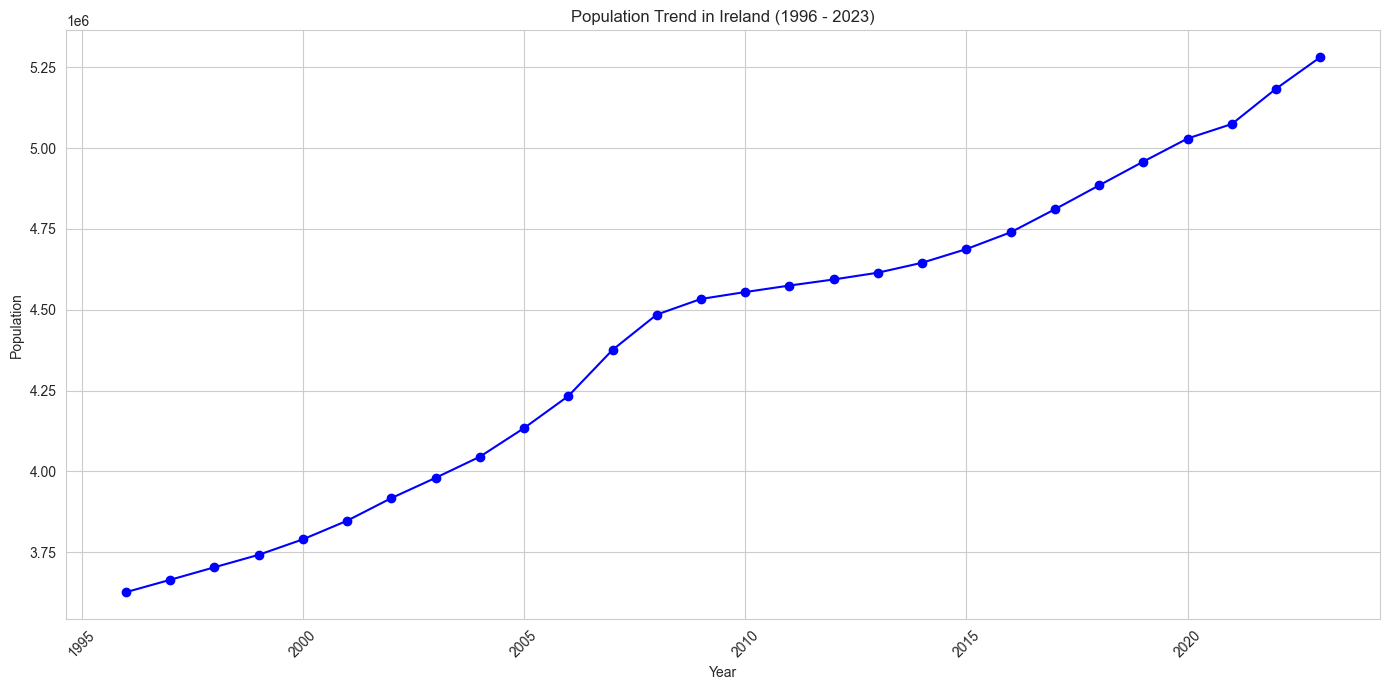

A time series plot to show the trend of net migration over the years.


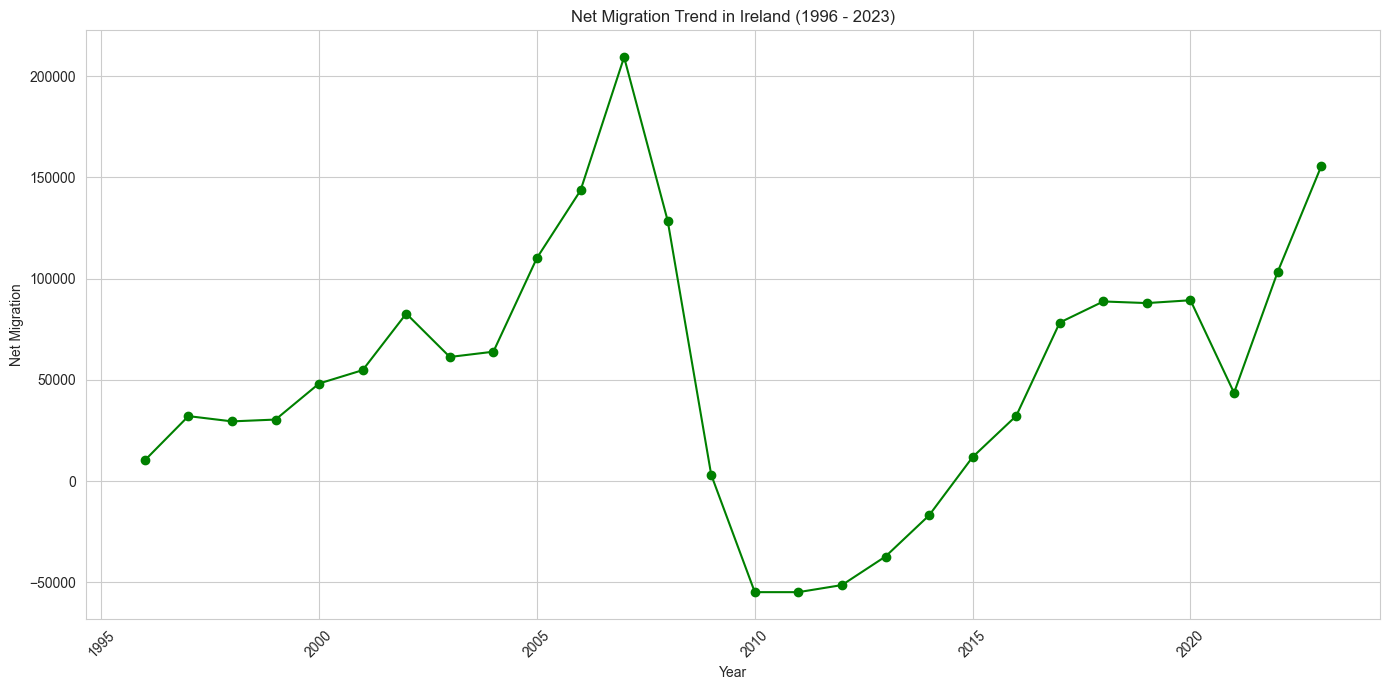

A scatter plot to visualize the relationship between net migration and population.


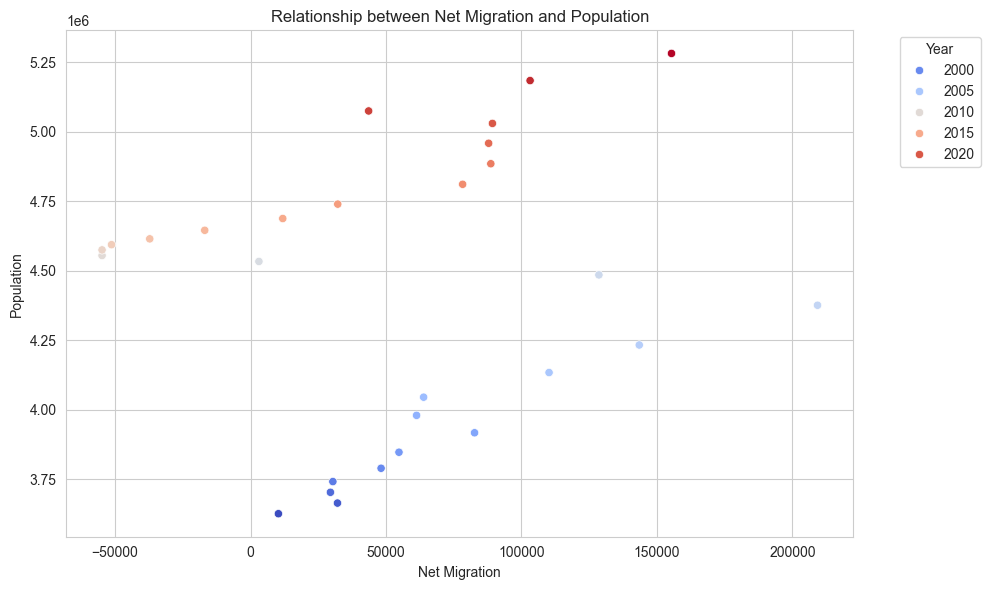

In [77]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

print('A time series plot to show the trend of the population over the years.')
# Time series plot for population
plt.figure(figsize=(14, 7))
plt.plot(merged_df_corrected['Year'], merged_df_corrected['Population'], marker='o', linestyle='-', color='blue')
plt.title('Population Trend in Ireland (1996 - 2023)')
plt.xlabel('Year')
plt.ylabel('Population')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

print('A time series plot to show the trend of net migration over the years.')
# Time series plot for net migration
plt.figure(figsize=(14, 7))
plt.plot(merged_df_corrected['Year'], merged_df_corrected['Net Migration'], marker='o', linestyle='-', color='green')
plt.title('Net Migration Trend in Ireland (1996 - 2023)')
plt.xlabel('Year')
plt.ylabel('Net Migration')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

print('A scatter plot to visualize the relationship between net migration and population.')
# Scatter plot for the relationship between net migration and population
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Net Migration', y='Population', data=merged_df_corrected, hue='Year', palette="coolwarm")
plt.title('Relationship between Net Migration and Population')
plt.xlabel('Net Migration')
plt.ylabel('Population')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()


**Insides:**
* Population Trend: This plot shows the trend of the population in Ireland from 1996 to 2023. It seems to show a consistent increase over the years.

* Net Migration Trend: This plot illustrates the trend of net migration over the same period. There are fluctuations from year to year, with some years experiencing negative net migration (more emigrants than immigrants).

* Relationship between Net Migration and Population: The scatter plot indicates the relationship between net migration and population size for each year. The color gradient represents the progression of years. It seems that there is a general positive correlation, suggesting that higher net migration is often associated with a higher population in the subsequent years.

#### Preparing the data for the ML

Splitting the data. I'll use the population as the target variable (y) and the year and net migration as features (X). Since I'm dealing with time series data, I should be careful to split the data in a time-aware manner, using chronological splits rather than random ones.

In [78]:
# Define the features and the target
X = merged_df_corrected[['Year', 'Net Migration']]
y = merged_df_corrected['Population']

# Since this is time series data, we'll manually split the data to maintain the time order
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Output the size of the training and test sets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((22, 2), (6, 2), (22,), (6,))

The data has been split into training and test sets, maintaining chronological order:

* Training set: 22 data points (80% of the data)
* Test set: 6 data points (20% of the data)

I'll start by training the following models using the training set:

* Ordinary Least Squares (OLS) Regression
* Ridge Regression
* Lasso Regression
* Random Forest

I'll then perform hyperparameter tuning for the Ridge, Lasso, and Random Forest models using cross-validation, and finally, I'll evaluate all models on the test set.

#### Training the OLS Regression (it doesn't require hyperparameter tuning)

In [79]:
# Initialize and train the OLS regression model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predict on the test set
y_pred_ols = ols_model.predict(X_test)

# Evaluate the OLS model
ols_mae = mean_absolute_error(y_test, y_pred_ols)
ols_rmse = mean_squared_error(y_test, y_pred_ols, squared=False)
ols_r2 = r2_score(y_test, y_pred_ols)

(ols_mae, ols_rmse, ols_r2)


(41492.6808142364, 45885.9002682968, 0.880926388939636)

The Ordinary Least Squares (OLS) regression model has been trained and evaluated on the test set with the following results:
* Mean Absolute Error (MAE): 41,492.68
* Root Mean Squared Error (RMSE): 45,885.90
* R-squared (R²): 0.881

The R-squared value of 0.881 indicates that our model explains about 88.1% of the variance in the test set population figures, which is a strong start.

#### Training the Ridge Regression

In [80]:
# Define the Ridge regression model
ridge = Ridge()

# Define a range of alpha values for hyperparameter tuning
parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

# Initialize GridSearchCV to find the best alpha (hyperparameter tuning)
ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training data
ridge_cv.fit(X_train, y_train)

# The best alpha value found
best_alpha_ridge = ridge_cv.best_params_['alpha']

# Train the Ridge regression model with the best alpha value
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the Ridge model
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test, y_pred_ridge)

(best_alpha_ridge, ridge_mae, ridge_rmse, ridge_r2)


(1, 40850.815560780466, 45130.81298364491, 0.8848130378899626)

The Ridge regression model has been trained with hyperparameter tuning, and the best alpha value found is 1. Here are the evaluation results on the test set:
* Mean Absolute Error (MAE): 40,850.82
* Root Mean Squared Error (RMSE): 45,130.81
* R-squared (R²): 0.885

The Ridge regression model shows a slight improvement over the OLS model, with a lower MAE and RMSE and a slightly higher R², indicating a better fit to the test data.

#### Training & Tuning the Lasso Regression

In [81]:
# Define the Lasso regression model
lasso = Lasso()

# Define a range of alpha values for hyperparameter tuning
parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

# Initialize GridSearchCV to find the best alpha (hyperparameter tuning)
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training data
lasso_cv.fit(X_train, y_train)

# The best alpha value found
best_alpha_lasso = lasso_cv.best_params_['alpha']

# Train the Lasso regression model with the best alpha value
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the Lasso model
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
lasso_r2 = r2_score(y_test, y_pred_lasso)

(best_alpha_lasso, lasso_mae, lasso_rmse, lasso_r2)


(10, 41490.36146771411, 45883.14564289537, 0.8809406849803105)

The Lasso regression model has been trained with hyperparameter tuning, and the best alpha value found is 10. The evaluation results on the test set are as follows:
* Mean Absolute Error (MAE): 41,490.36
* Root Mean Squared Error (RMSE): 45,883.15
* R-squared (R²): 0.881

The Lasso regression results are very close to the OLS model, with a similar R² and slightly worse MAE and RMSE. This suggests that the regularization introduced by Lasso may not be significantly improving the model for this particular dataset, or the feature set is already quite optimal.

####  Trainingn & Tunning the Random Forest

In [82]:
# Define the Random Forest regression model
random_forest = RandomForestRegressor(random_state=0)

# Define a range of hyperparameters for tuning
# We'll look at the number of estimators and the maximum depth of the trees
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
}

# Initialize GridSearchCV to find the best hyperparameters (hyperparameter tuning)
rf_cv = GridSearchCV(random_forest, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training data
rf_cv.fit(X_train, y_train)

# The best hyperparameters found
best_params_rf = rf_cv.best_params_

# Train the Random Forest regression model with the best hyperparameters
rf_model = RandomForestRegressor(**best_params_rf, random_state=0)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)

(best_params_rf, rf_mae, rf_rmse, rf_r2)


({'max_depth': 5, 'n_estimators': 100},
 312113.16499999986,
 345489.60755728395,
 -5.750360814946282)

The Random Forest regression model has been trained and tuned, with the best parameters found being:
* Maximum Depth: 5
* Number of Estimators: 100

The performance metrics on the test set, however, are significantly worse than the linear models:

* Mean Absolute Error (MAE): 312,113.16
* Root Mean Squared Error (RMSE): 345,489.61
* R-squared (R²): -5.75

**Insides:**\
The negative R-squared value indicates that the Random Forest model performs worse than a horizontal line fit to the data. This poor performance may be due to overfitting on the training set or not having enough data to capture the complexity that Random Forest can handle.

Given these results, the Random Forest model does not seem appropriate for this particular problem with the given dataset. The linear models, especially the Ridge regression with the best performance metrics, are more suitable for predicting the population based on the year and net migration data.

#### Train the ElasticNet Regression

In [83]:
# Define the ElasticNet regression model
elastic_net = ElasticNet()

# Define a range of alpha values and the l1_ratio for hyperparameter tuning
# The l1_ratio corresponds to the mix of L1 and L2 regularization
parameters = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Initialize GridSearchCV to find the best alpha and l1_ratio (hyperparameter tuning)
en_cv = GridSearchCV(elastic_net, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training data
en_cv.fit(X_train, y_train)

# The best parameters found
best_params_en = en_cv.best_params_

# Train the ElasticNet regression model with the best parameters
elastic_net_model = ElasticNet(**best_params_en)
elastic_net_model.fit(X_train, y_train)

# Predict on the test set
y_pred_en = elastic_net_model.predict(X_test)

# Evaluate the ElasticNet model
en_mae = mean_absolute_error(y_test, y_pred_en)
en_rmse = mean_squared_error(y_test, y_pred_en, squared=False)
en_r2 = r2_score(y_test, y_pred_en)

(best_params_en, en_mae, en_rmse, en_r2)


({'alpha': 1, 'l1_ratio': 0.9},
 40082.365630577006,
 44246.62353490334,
 0.8892822424475426)

The ElasticNet regression model has been trained with hyperparameter tuning, and the best parameters found are an alpha of 1 and an 
an *l2_ration* of 0.9
Here are the evaluation results on the test set:

* Mean Absolute Error (MAE): 40,082.37
* Root Mean Squared Error (RMSE): 44,246.62
* R-squared (R²): 0.889

The ElasticNet model shows an improvement over both the OLS and Lasso models and is comparable to the Ridge model. The 
*l1_ration* close to 1 suggests that the model is leaning more towards Lasso regularization, but the combination with Ridge regularization (L2) is still providing a slight benefit.

Given these results, ElasticNet offers a good balance between Ridge and Lasso and could be a preferred model when dealing with datasets that may have multicollinearity or when we want to include the benefits of both L1 and L2 regularization.

#### Models comparison

Ordinary Least Squares (OLS) Regression:
* MAE: 41,492.68
* RMSE: 45,885.90
* R²: 0.881
  
Ridge Regression (with hyperparameter tuning):
* MAE: 40,850.82
* RMSE: 45,130.81
* R²: 0.885
  
Lasso Regression (with hyperparameter tuning):
* MAE: 41,490.36
* RMSE: 45,883.15
* R²: 0.881
  
Random Forest Regression (with hyperparameter tuning):
* MAE: 312,113.16
* RMSE: 345,489.61
* R²: -5.75

**Insides:**
* The **OLS regression** provided a strong baseline with an R² of 0.881, suggesting that the model explains about 88.1% of the variability in the test data.
* **Ridge regression** showed a slight improvement over OLS, indicating that the L2 regularization helped reduce overfitting and improve the model's generalization on the test data.
* **Lasso regression** did not improve the performance compared to OLS, suggesting that feature selection through L1 regularization was not beneficial, possibly because both features used (year and net migration) were relevant for the model.
* **The Random Forest regression** performed poorly, which might be due to the small dataset size, leading to overfitting despite hyperparameter tuning. The negative R² indicates that the model is worse than a simple mean-based prediction, which is not desirable.

In [84]:
# Data for plotting
model_names = ['OLS', 'Ridge', 'Lasso', 'Random Forest']
mae_values = [ols_mae, ridge_mae, lasso_mae, rf_mae]
rmse_values = [ols_rmse, ridge_rmse, lasso_rmse, rf_rmse]
r2_values = [ols_r2, ridge_r2, lasso_r2, rf_r2]

# Update our data for plotting with ElasticNet results
model_names.append('ElasticNet')
mae_values.append(en_mae)
rmse_values.append(en_rmse)
r2_values.append(en_r2)


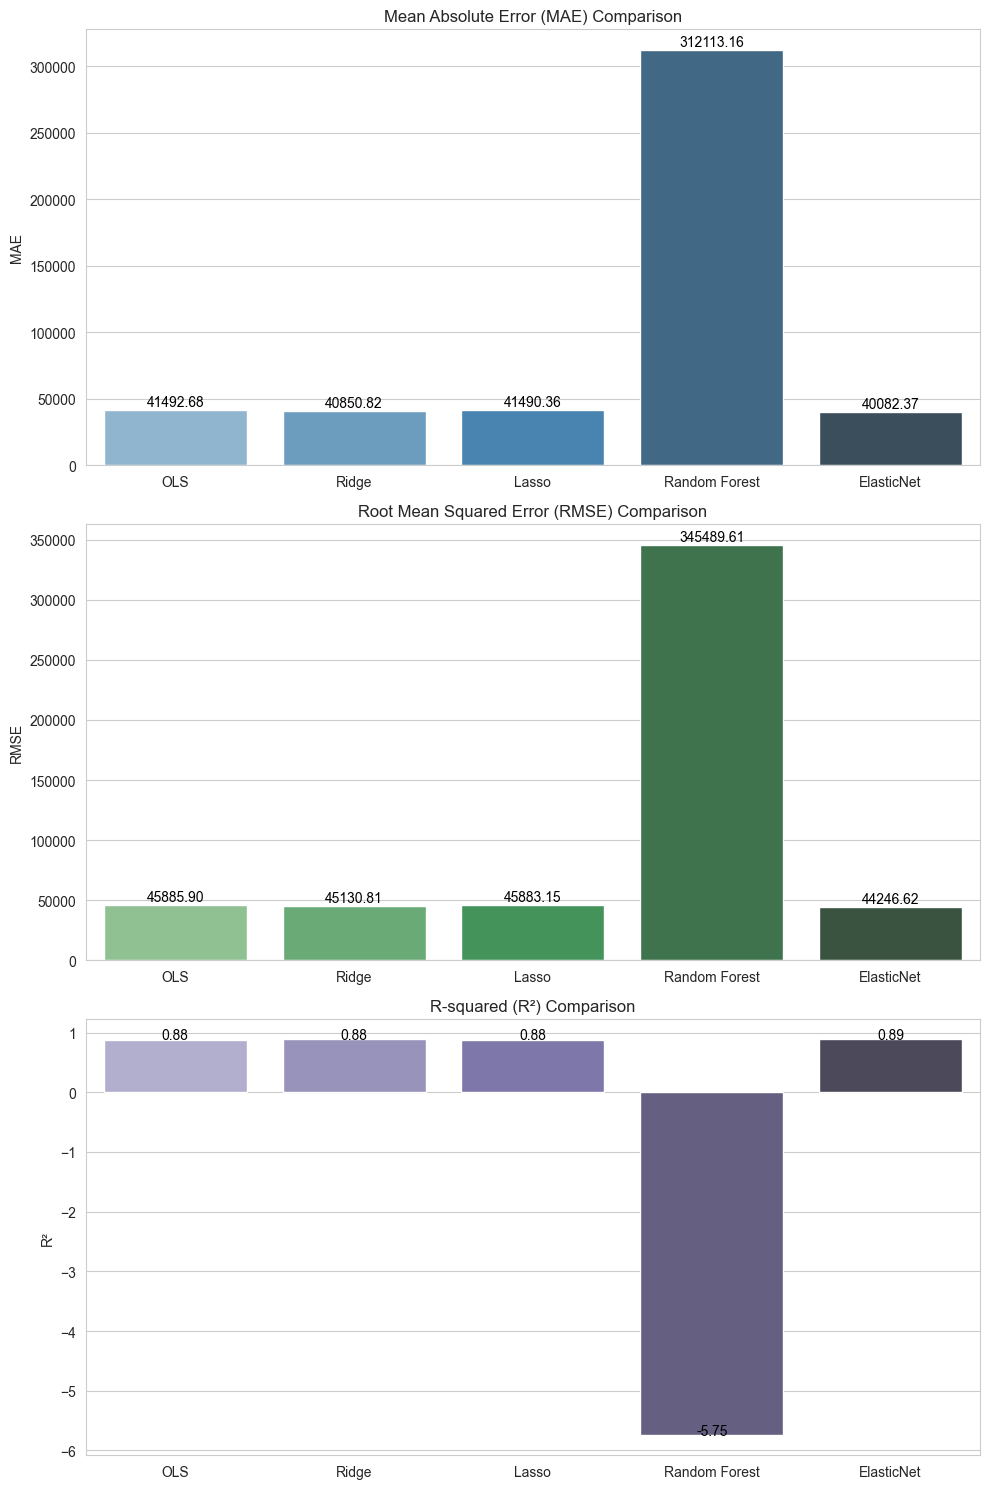

In [85]:
# Separate plots for each metric for better visibility
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# MAE plot
sns.barplot(ax=ax[0], x=model_names, y=mae_values, palette="Blues_d")
ax[0].set_title('Mean Absolute Error (MAE) Comparison')
ax[0].set_ylabel('MAE')
for i, v in enumerate(mae_values):
    ax[0].text(i, v + max(mae_values)*0.01, f"{v:.2f}", color='black', ha='center')

# RMSE plot
sns.barplot(ax=ax[1], x=model_names, y=rmse_values, palette="Greens_d")
ax[1].set_title('Root Mean Squared Error (RMSE) Comparison')
ax[1].set_ylabel('RMSE')
for i, v in enumerate(rmse_values):
    ax[1].text(i, v + max(rmse_values)*0.01, f"{v:.2f}", color='black', ha='center')

# R-squared plot
sns.barplot(ax=ax[2], x=model_names, y=r2_values, palette="Purples_d")
ax[2].set_title('R-squared (R²) Comparison')
ax[2].set_ylabel('R²')
for i, v in enumerate(r2_values):
    ax[2].text(i, v + max(r2_values)*0.01, f"{v:.2f}", color='black', ha='center')

plt.tight_layout()
plt.show()


The **Mean Squared Error (MSE)** can sometimes be misunderstood because its scale is dependent on the scale of the target variable. In our case, the target variable is the population, which can be a large number (in the millions). Hence, the MSE will also be a large number because it is the average of the squared differences between the predicted values and the actual values.

For instance, if the actual population is 4,000,000 and the predicted population is 4,041,493 (which would give us an MAE around 41,493 as we saw earlier), the squared error for this single prediction would be:

                  (4,041,493−4,000,000)² =1,721,592,849

When you average these large squared errors across all predictions, you end up with a large MSE. This doesn't mean the model is performing poorly; it's just a reflection of the scale of the data you are predicting.

To get a more intuitive sense of the error, we often take the square root of the MSE to get the RMSE (Root Mean Squared Error), which brings the error back to the original scale of the data. The RMSE for the OLS was around 45,885.90, which is on the same scale as the population numbers we're predicting.

If you're expecting a number like 0.1369 for the MSE, it sounds like you might be thinking of a normalized error metric, where the error is divided by the variance of the target variable, or an error metric for a model that predicts a scaled version of the target variable.

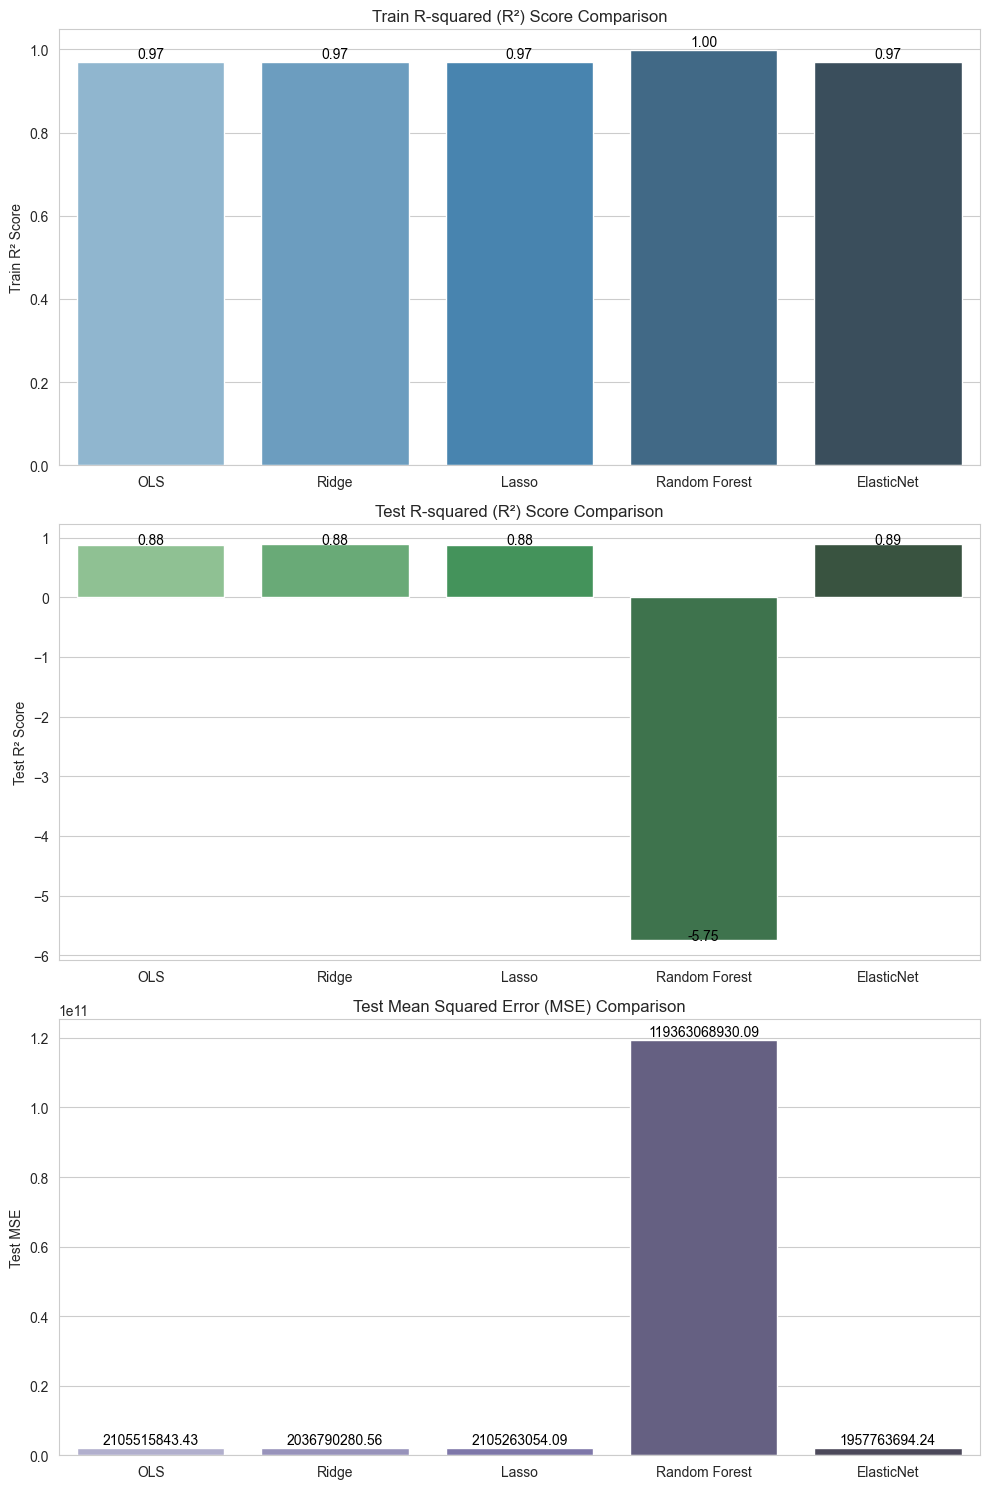

In [86]:
# Calculate and store training R² and test MSE for each model
train_r2_scores = [
    ols_model.score(X_train, y_train),
    ridge_model.score(X_train, y_train),
    lasso_model.score(X_train, y_train),
    rf_model.score(X_train, y_train),
    elastic_net_model.score(X_train, y_train)
]

test_mse_scores = [
    mean_squared_error(y_test, y_pred_ols),
    mean_squared_error(y_test, y_pred_ridge),
    mean_squared_error(y_test, y_pred_lasso),
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_en)
]

# Create a DataFrame to hold all the scores for easier plotting
score_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Train R²': train_r2_scores,
    'Test R²': r2_values,
    'Test MSE': test_mse_scores
})

score_comparison_df.set_index('Model', inplace=True)

# Separate plots for each metric for better visibility with the added Train R² and Test MSE
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Train R² plot
sns.barplot(ax=ax[0], x=model_names, y=train_r2_scores, palette="Blues_d")
ax[0].set_title('Train R-squared (R²) Score Comparison')
ax[0].set_ylabel('Train R² Score')
for i, v in enumerate(train_r2_scores):
    ax[0].text(i, v + max(train_r2_scores)*0.01, f"{v:.2f}", color='black', ha='center')

# Test R² plot
sns.barplot(ax=ax[1], x=model_names, y=r2_values, palette="Greens_d")
ax[1].set_title('Test R-squared (R²) Score Comparison')
ax[1].set_ylabel('Test R² Score')
for i, v in enumerate(r2_values):
    ax[1].text(i, v + max(r2_values)*0.01, f"{v:.2f}", color='black', ha='center')

# Test MSE plot
sns.barplot(ax=ax[2], x=model_names, y=test_mse_scores, palette="Purples_d")
ax[2].set_title('Test Mean Squared Error (MSE) Comparison')
ax[2].set_ylabel('Test MSE')
for i, v in enumerate(test_mse_scores):
    ax[2].text(i, v + max(test_mse_scores)*0.01, f"{v:.2f}", color='black', ha='center')

plt.tight_layout()
plt.show()


In [87]:
# Initialize and train the OLS regression model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predict on the test set
y_pred_ols = ols_model.predict(X_test)

# Now we move onto Ridge regression, tuning it with GridSearchCV
ridge = Ridge()
parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Next is Lasso regression
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Now, we'll train the Random Forest regressor
random_forest = RandomForestRegressor(random_state=0)
parameters_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
}
rf_cv = GridSearchCV(random_forest, parameters_rf, scoring='neg_mean_squared_error', cv=5)
rf_cv.fit(X_train, y_train)
best_params_rf = rf_cv.best_params_
rf_model = RandomForestRegressor(**best_params_rf, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Finally, ElasticNet regression
elastic_net = ElasticNet()
parameters_en = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}
en_cv = GridSearchCV(elastic_net, parameters_en, scoring='neg_mean_squared_error', cv=5)
en_cv.fit(X_train, y_train)
best_params_en = en_cv.best_params_
elastic_net_model = ElasticNet(**best_params_en)
elastic_net_model.fit(X_train, y_train)
y_pred_en = elastic_net_model.predict(X_test)

# Gather all predictions in a dataframe for comparison
predictions = {
    'Actual': y_test,
    'OLS': y_pred_ols,
    'Ridge': y_pred_ridge,
    'Lasso': y_pred_lasso,
    'Random_Forest': y_pred_rf,
    'ElasticNet': y_pred_en
}

predictions_df = pd.DataFrame(predictions)
predictions_df.reset_index(drop=True, inplace=True) # Reset index for clean plotting

test_years = X_test['Year'].tolist()
predictions_df['Year'] = test_years
predictions_df = predictions_df.astype(int) # Convert to int for cleaner formatting
predictions_df = predictions_df[['Year', 'Actual', 'OLS', 'Ridge', 'Lasso', 'Random_Forest', 'ElasticNet']]
predictions_df


,Year,Actual,OLS,Ridge,Lasso,Random_Forest,ElasticNet
0,2018,4884896,4950789,4949880,4950786,4766881,4948790
1,2019,4958471,5012006,5011024,5012002,4766881,5009850
2,2020,5029875,5073458,5072402,5073454,4766881,5071137
3,2021,5074668,5129862,5128804,5129858,4760795,5127538
4,2022,5183966,5197552,5196328,5197547,4766881,5194864
5,2023,5281612,5264448,5263071,5264443,4712486,5261422


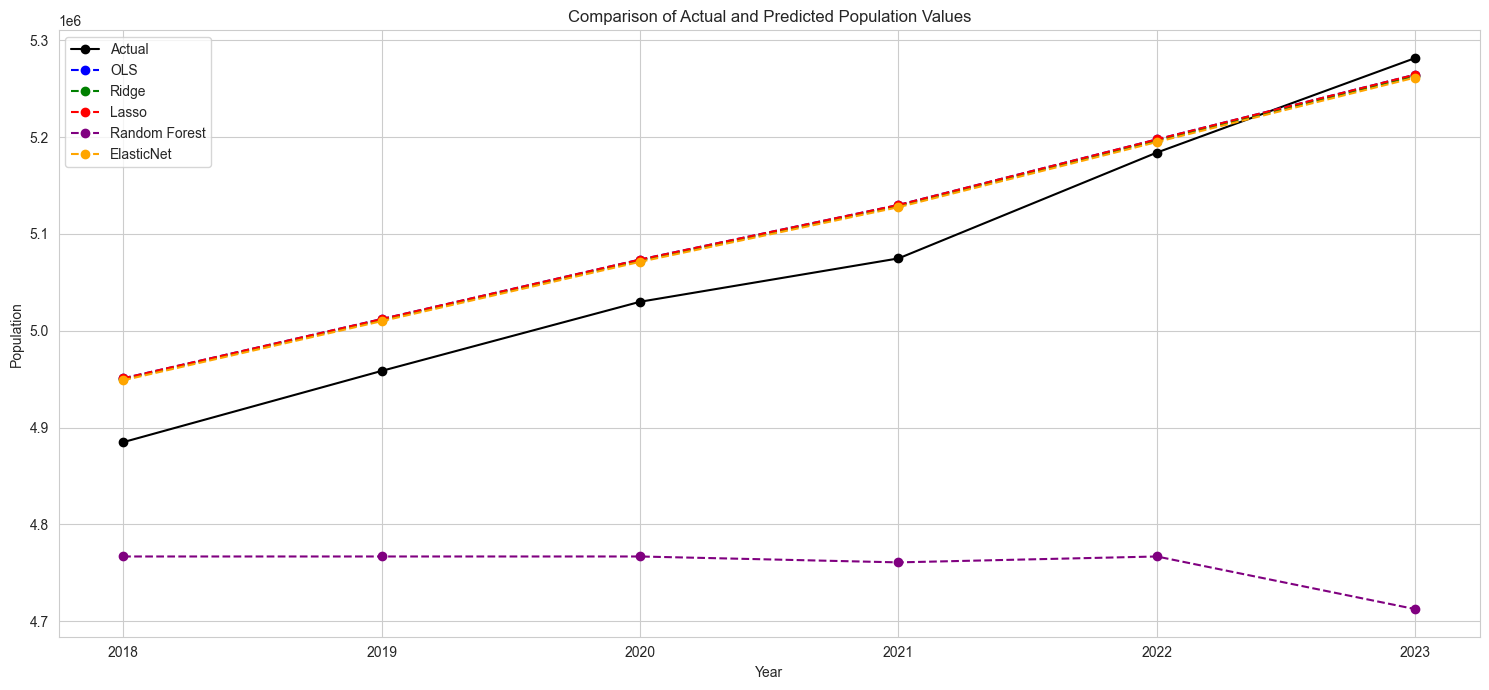

In [88]:
# Plotting the actual and predicted population values
plt.figure(figsize=(15, 7))

# Actual population values
plt.plot(predictions_df['Year'], predictions_df['Actual'], label='Actual', color='black', marker='o')

# Predictions from different models
plt.plot(predictions_df['Year'], predictions_df['OLS'], label='OLS', color='blue', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Ridge'], label='Ridge', color='green', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Lasso'], label='Lasso', color='red', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Random_Forest'], label='Random Forest', color='purple', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['ElasticNet'], label='ElasticNet', color='orange', linestyle='--', marker='o')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Population Values')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.xticks(predictions_df['Year'].values) # Set x-ticks to be the years
plt.tight_layout() # Adjust the layout to make room for the legend

# Show the plot
plt.show()


The plot above illustrates the actual population values compared with the predictions made by each model for the years in the test set. The solid black line represents the actual population, while the dashed lines represent the predictions from the various regression models. This visual comparison can help in understanding how well each model is able to track the actual population trend.​

**Insights**
1. Actual Trend: The actual population shows a steady increase over the years in the dataset.

2. Model Performance:

* OLS (Ordinary Least Squares), Ridge, Lasso, and ElasticNet models show a relatively similar performance in terms of following the trend of the actual population. This indicates that despite the regularization terms in Ridge, Lasso, and ElasticNet, the linear nature of these models produces similar results for this particular dataset.
* The Random Forest model exhibits a different pattern, with predictions that are consistently lower than the actual population figures and the other models' predictions. This suggests that the Random Forest model might not have captured the trend in the data as effectively as the linear models. This could be due to overfitting to the training data or not having enough features that capture the time series nature of the data.
  
3. Consistency:

* The linear models (OLS, Ridge, Lasso, ElasticNet) are consistent with each other but tend to underestimate the population in later years. This might be because the trend is not perfectly linear and there might be other factors influencing population growth that are not captured by the model features.
* The Random Forest model's predictions are consistent within its own trend but are quite off from the actual data, indicating it may have missed key time-related dependencies or interactions between features.
  
4. Potential for Improvement:

* The deviations between the predictions and actual figures suggest that there may be non-linear patterns or additional factors that affect the population growth that are not being accounted for by the current features in the models.
* Incorporating additional features that could impact population growth, such as economic indicators, fertility rates, mortality rates, or even international migration patterns, might improve model performance.
* Since we're dealing with time series data, using models that can capture temporal dynamics, such as ARIMA (Autoregressive Integrated Moving Average), SARIMA (Seasonal ARIMA), or LSTM (Long Short-Term Memory networks), could potentially provide more accurate predictions.
  
5. Projection to Future:

* If we were to use these models to project future population, the current evidence suggests that the linear models would likely give similar trajectories, but the actual future population could be higher than predicted if recent trends continue.
* The Random Forest model would likely underestimate future population unless it's retrained with additional data or more complex features that better capture the underlying population dynamics.
In conclusion, while the linear models seem to perform adequately, there is room for improvement, especially in capturing non-linear trends and other potential influences on population growth. Advanced time series models or machine learning approaches that can handle sequences and external factors could provide better insights and predictions.